In [2]:
import json
import os
import logging
import pandas as pd
from dataclasses import asdict

# Import your pipeline's Triage module and the evaluation functions
from triage import TriageClassifier
from run_batch_evaluation import run_evaluation

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display

# Configure notebook environment
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
sns.set_theme(style="whitegrid", rc={"figure.figsize": (12, 8)})
pd.set_option('display.max_colwidth', 100)

In [3]:
# Consolidate the Dataset
logging.info("--- Step 1: Consolidating Datasets ---")

# Load original tickets
try:
    with open('sample_tickets.json', 'r') as f:
        original_tickets = json.load(f)
except FileNotFoundError:
    logging.error("'sample_tickets.json' not found. Aborting.")
    original_tickets = []
    
# Add 15 generated tickets
new_tickets = [
      {"id": "TICKET-275", "subject": "MongoDB Atlas Connector - Not seeing collections", "body": "Hi, we've set up the MongoDB Atlas connector..."},
      {"id": "TICKET-276", "subject": "Incorrect lineage showing extra hop", "body": "The lineage for our `dim_users` table seems incorrect..."},
      {"id": "TICKET-277", "subject": "Rate limiting on API for bulk updates", "body": "We are trying to programmatically apply a 'data-quality-certified' tag..."},
      {"id": "TICKET-278", "subject": "Conflict between Persona and Purpose policies", "body": "We have a data steward who is part of a 'Data Governance' Persona..."},
      {"id": "TICKET-279", "subject": "SCIM de-provisioning not revoking access", "body": "We have configured SCIM with our Azure AD..."},
      {"id": "TICKET-280", "subject": "What's the difference between a 'Verified' asset and a 'Draft' asset?", "body": "Some of our assets have a green checkmark and say 'Verified'..."},
      {"id": "TICKET-281", "subject": "UI is slow when viewing assets with many columns", "body": "We have a few very wide tables in our data warehouse..."},
      {"id": "TICKET-282", "subject": "Implementing Data Mesh concepts in Atlan", "body": "Our organization is moving towards a data mesh architecture..."},
      {"id": "TICKET-283", "subject": "Is it possible to get lineage from a stored procedure?", "body": "A lot of our core business logic is encapsulated in complex Snowflake stored procedures..."},
      {"id": "TICKET-284", "subject": "Querying Power BI datasets via Atlan", "body": "I can see all of our Power BI workspaces, reports, and datasets in Atlan..."},
      {"id": "TICKET-285", "subject": "How to handle API token rotation securely?", "body": "Our security policy requires that all API tokens used in production services must be rotated..."},
      {"id": "TICKET-286", "subject": "Tableau workbook lineage showing incorrect upstream sources", "body": "We have a Tableau workbook that sources data from a specific view..."},
      {"id": "TICKET-287", "subject": "Propagating tags through lineage", "body": "I've tagged a column in our source table as 'PII'..."},
      {"id": "TICKET-288", "subject": "Urgent: 'Internal Server Error' when accessing Governance tab", "body": "This is a critical issue. None of our admins can access the Governance tab..."},
      {"id": "TICKET-289", "subject": "Guidance on using custom metadata vs. tags", "body": "I'm trying to decide how to model some new metadata for our assets..."}
    ]

full_dataset = original_tickets + new_tickets
logging.info(f"Consolidated dataset contains {len(full_dataset)} tickets.")

2025-09-15 04:28:57,221 - INFO - --- Step 1: Consolidating Datasets ---
2025-09-15 04:28:57,224 - INFO - Consolidated dataset contains 45 tickets.


Now, we will run all 45 tickets through the TriageClassifier to generate the predictions that will form the basis of our evaluation.

In [5]:
import time
logging.info("--- Step 2: Classifying All Tickets ---")
classifier = TriageClassifier()
classified_results = []

for i, ticket in enumerate(full_dataset):
    print(f"Classifying ticket {i+1}/{len(full_dataset)}: {ticket['id']}", end='\r')
    ticket_data = {'id': ticket['id'], 'subject': ticket['subject'], 'body': ticket['body']}
    try:
        result = classifier.classify_ticket(ticket_data)
    except Exception as e:
        if 'Resource exhausted' in str(e):
            print("Resource exhausted. Waiting 60 seconds...")
            time.sleep(60)
            result = classifier.classify_ticket(ticket_data)
        else:
            print(f"Error: {e}")
            result = None
    if result is not None:
        result_dict = asdict(result)
        result_dict['body'] = ticket['body'] 
        classified_results.append(result_dict)

classified_df = pd.DataFrame(classified_results)
print("\nClassification complete.")
display(classified_df[['ticket_id', 'topics', 'priority', 'confidence', 'reasoning']].head())

2025-09-15 04:33:29,219 - INFO - --- Step 2: Classifying All Tickets ---
2025-09-15 04:33:29,251 - INFO - Use pytorch device_name: mps
2025-09-15 04:33:29,251 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-09-15 04:33:29,251 - INFO - Use pytorch device_name: mps
2025-09-15 04:33:29,251 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-09-15 04:33:34,422 - INFO - AFC is enabled with max remote calls: 10.


2025-09-15 04:33:37,238 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-15 04:33:37,242 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:37,243 - INFO - ✅ Classified ticket TICKET-245: ['CONNECTOR', 'HOW_TO'] (confidence: 0.950)
2025-09-15 04:33:37,244 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:33:37,242 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:37,243 - INFO - ✅ Classified ticket TICKET-245: ['CONNECTOR', 'HOW_TO'] (confidence: 0.950)
2025-09-15 04:33:37,244 - INFO - AFC is enabled with max remote calls: 10.


2025-09-15 04:33:38,669 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-15 04:33:38,670 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:38,670 - INFO - ✅ Classified ticket TICKET-246: ['HOW_TO', 'CONNECTOR', 'LINEAGE'] (confidence: 0.900)
2025-09-15 04:33:38,670 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:33:38,670 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:38,670 - INFO - ✅ Classified ticket TICKET-246: ['HOW_TO', 'CONNECTOR', 'LINEAGE'] (confidence: 0.900)
2025-09-15 04:33:38,670 - INFO - AFC is enabled with max remote calls: 10.


2025-09-15 04:33:39,796 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-15 04:33:39,797 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:39,798 - INFO - ✅ Classified ticket TICKET-247: ['CONNECTOR', 'HOW_TO'] (confidence: 0.900)
2025-09-15 04:33:39,798 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:33:39,797 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:39,798 - INFO - ✅ Classified ticket TICKET-247: ['CONNECTOR', 'HOW_TO'] (confidence: 0.900)
2025-09-15 04:33:39,798 - INFO - AFC is enabled with max remote calls: 10.


2025-09-15 04:33:41,146 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-15 04:33:41,147 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:41,147 - INFO - ✅ Classified ticket TICKET-248: ['HOW_TO', 'CONNECTOR'] (confidence: 0.900)
2025-09-15 04:33:41,148 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:33:41,147 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:41,147 - INFO - ✅ Classified ticket TICKET-248: ['HOW_TO', 'CONNECTOR'] (confidence: 0.900)
2025-09-15 04:33:41,148 - INFO - AFC is enabled with max remote calls: 10.


2025-09-15 04:33:42,168 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-15 04:33:42,171 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:42,171 - INFO - ✅ Classified ticket TICKET-249: ['LINEAGE', 'HOW_TO'] (confidence: 0.900)
2025-09-15 04:33:42,172 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:33:42,171 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:42,171 - INFO - ✅ Classified ticket TICKET-249: ['LINEAGE', 'HOW_TO'] (confidence: 0.900)
2025-09-15 04:33:42,172 - INFO - AFC is enabled with max remote calls: 10.


2025-09-15 04:33:43,539 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-15 04:33:43,541 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:43,541 - INFO - ✅ Classified ticket TICKET-250: ['HOW_TO', 'CONNECTOR', 'LINEAGE'] (confidence: 0.900)
2025-09-15 04:33:43,541 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:33:43,541 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:43,541 - INFO - ✅ Classified ticket TICKET-250: ['HOW_TO', 'CONNECTOR', 'LINEAGE'] (confidence: 0.900)
2025-09-15 04:33:43,541 - INFO - AFC is enabled with max remote calls: 10.


2025-09-15 04:33:44,601 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-15 04:33:44,603 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:44,603 - INFO - ✅ Classified ticket TICKET-251: ['HOW_TO', 'PRODUCT'] (confidence: 0.900)
2025-09-15 04:33:44,604 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:33:44,603 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:44,603 - INFO - ✅ Classified ticket TICKET-251: ['HOW_TO', 'PRODUCT'] (confidence: 0.900)
2025-09-15 04:33:44,604 - INFO - AFC is enabled with max remote calls: 10.


2025-09-15 04:33:45,920 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-15 04:33:45,922 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:45,923 - INFO - ✅ Classified ticket TICKET-252: ['LINEAGE', 'API_SDK'] (confidence: 0.900)
2025-09-15 04:33:45,924 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:33:45,922 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:45,923 - INFO - ✅ Classified ticket TICKET-252: ['LINEAGE', 'API_SDK'] (confidence: 0.900)
2025-09-15 04:33:45,924 - INFO - AFC is enabled with max remote calls: 10.


2025-09-15 04:33:47,171 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-15 04:33:47,173 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:47,173 - INFO - ✅ Classified ticket TICKET-253: ['CONNECTOR', 'LINEAGE', 'PRODUCT'] (confidence: 0.900)
2025-09-15 04:33:47,174 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:33:47,173 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:47,173 - INFO - ✅ Classified ticket TICKET-253: ['CONNECTOR', 'LINEAGE', 'PRODUCT'] (confidence: 0.900)
2025-09-15 04:33:47,174 - INFO - AFC is enabled with max remote calls: 10.


2025-09-15 04:33:48,527 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-15 04:33:48,528 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:48,529 - INFO - ✅ Classified ticket TICKET-254: ['GLOSSARY', 'API_SDK', 'OTHER'] (confidence: 0.900)
2025-09-15 04:33:48,529 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:33:48,528 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:48,529 - INFO - ✅ Classified ticket TICKET-254: ['GLOSSARY', 'API_SDK', 'OTHER'] (confidence: 0.900)
2025-09-15 04:33:48,529 - INFO - AFC is enabled with max remote calls: 10.


2025-09-15 04:33:49,537 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-15 04:33:49,539 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:49,539 - INFO - ✅ Classified ticket TICKET-255: ['HOW_TO', 'GLOSSARY', 'BEST_PRACTICES'] (confidence: 0.800)
2025-09-15 04:33:49,539 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:33:49,539 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:49,539 - INFO - ✅ Classified ticket TICKET-255: ['HOW_TO', 'GLOSSARY', 'BEST_PRACTICES'] (confidence: 0.800)
2025-09-15 04:33:49,539 - INFO - AFC is enabled with max remote calls: 10.


2025-09-15 04:33:50,958 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-15 04:33:50,960 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:50,960 - INFO - ✅ Classified ticket TICKET-256: ['SSO', 'HOW_TO'] (confidence: 0.900)
2025-09-15 04:33:50,961 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:33:50,960 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:50,960 - INFO - ✅ Classified ticket TICKET-256: ['SSO', 'HOW_TO'] (confidence: 0.900)
2025-09-15 04:33:50,961 - INFO - AFC is enabled with max remote calls: 10.


2025-09-15 04:33:52,010 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-15 04:33:52,012 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:52,013 - INFO - ✅ Classified ticket TICKET-257: ['HOW_TO', 'GLOSSARY', 'SENSITIVE_DATA'] (confidence: 0.900)
2025-09-15 04:33:52,013 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:33:52,012 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:52,013 - INFO - ✅ Classified ticket TICKET-257: ['HOW_TO', 'GLOSSARY', 'SENSITIVE_DATA'] (confidence: 0.900)
2025-09-15 04:33:52,013 - INFO - AFC is enabled with max remote calls: 10.


2025-09-15 04:33:53,315 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-15 04:33:53,317 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:53,318 - INFO - ✅ Classified ticket TICKET-258: ['HOW_TO', 'BEST_PRACTICES'] (confidence: 0.900)
2025-09-15 04:33:53,319 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:33:53,317 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:53,318 - INFO - ✅ Classified ticket TICKET-258: ['HOW_TO', 'BEST_PRACTICES'] (confidence: 0.900)
2025-09-15 04:33:53,319 - INFO - AFC is enabled with max remote calls: 10.


2025-09-15 04:33:54,408 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-15 04:33:54,412 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:54,413 - INFO - ✅ Classified ticket TICKET-259: ['SENSITIVE_DATA'] (confidence: 0.900)
2025-09-15 04:33:54,414 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:33:54,412 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:54,413 - INFO - ✅ Classified ticket TICKET-259: ['SENSITIVE_DATA'] (confidence: 0.900)
2025-09-15 04:33:54,414 - INFO - AFC is enabled with max remote calls: 10.


2025-09-15 04:33:55,772 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-15 04:33:55,776 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:55,777 - INFO - ✅ Classified ticket TICKET-260: ['API_SDK', 'HOW_TO'] (confidence: 0.900)
2025-09-15 04:33:55,778 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:33:55,776 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:55,777 - INFO - ✅ Classified ticket TICKET-260: ['API_SDK', 'HOW_TO'] (confidence: 0.900)
2025-09-15 04:33:55,778 - INFO - AFC is enabled with max remote calls: 10.


2025-09-15 04:33:56,944 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-15 04:33:56,949 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:56,950 - INFO - ✅ Classified ticket TICKET-261: ['SSO', 'HOW_TO'] (confidence: 0.900)
2025-09-15 04:33:56,950 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:33:56,949 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:56,950 - INFO - ✅ Classified ticket TICKET-261: ['SSO', 'HOW_TO'] (confidence: 0.900)
2025-09-15 04:33:56,950 - INFO - AFC is enabled with max remote calls: 10.


2025-09-15 04:33:58,227 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-15 04:33:58,231 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:58,232 - INFO - ✅ Classified ticket TICKET-262: ['SSO', 'OTHER'] (confidence: 0.900)
2025-09-15 04:33:58,233 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:33:58,231 - INFO - AFC remote call 1 is done.
2025-09-15 04:33:58,232 - INFO - ✅ Classified ticket TICKET-262: ['SSO', 'OTHER'] (confidence: 0.900)
2025-09-15 04:33:58,233 - INFO - AFC is enabled with max remote calls: 10.


2025-09-15 04:33:58,640 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:33:58,643 - ERROR - ❌ Error classifying ticket TICKET-263: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de

2025-09-15 04:33:59,860 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:33:59,864 - ERROR - ❌ Error classifying ticket TICKET-264: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de

2025-09-15 04:34:00,276 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:34:00,278 - ERROR - ❌ Error classifying ticket TICKET-265: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de

2025-09-15 04:34:02,302 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-15 04:34:02,305 - INFO - AFC remote call 1 is done.
2025-09-15 04:34:02,306 - INFO - ✅ Classified ticket TICKET-266: ['API_SDK', 'GLOSSARY', 'HOW_TO'] (confidence: 0.900)
2025-09-15 04:34:02,306 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:34:02,305 - INFO - AFC remote call 1 is done.
2025-09-15 04:34:02,306 - INFO - ✅ Classified ticket TICKET-266: ['API_SDK', 'GLOSSARY', 'HOW_TO'] (confidence: 0.900)
2025-09-15 04:34:02,306 - INFO - AFC is enabled with max remote calls: 10.


2025-09-15 04:34:02,733 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:34:02,736 - ERROR - ❌ Error classifying ticket TICKET-267: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-2.5-flash-lite', 'location': 'global'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de

2025-09-15 04:34:04,599 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-15 04:34:04,603 - INFO - AFC remote call 1 is done.
2025-09-15 04:34:04,603 - INFO - ✅ Classified ticket TICKET-268: ['API_SDK', 'SENSITIVE_DATA', 'OTHER'] (confidence: 0.900)
2025-09-15 04:34:04,604 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:34:04,603 - INFO - AFC remote call 1 is done.
2025-09-15 04:34:04,603 - INFO - ✅ Classified ticket TICKET-268: ['API_SDK', 'SENSITIVE_DATA', 'OTHER'] (confidence: 0.900)
2025-09-15 04:34:04,604 - INFO - AFC is enabled with max remote calls: 10.


2025-09-15 04:34:04,942 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:34:04,946 - ERROR - ❌ Error classifying ticket TICKET-269: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de

2025-09-15 04:34:06,319 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:34:06,323 - ERROR - ❌ Error classifying ticket TICKET-270: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-2.5-flash-lite', 'location': 'global'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de

2025-09-15 04:34:06,660 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:34:06,663 - ERROR - ❌ Error classifying ticket TICKET-271: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de

2025-09-15 04:34:07,972 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:34:07,975 - ERROR - ❌ Error classifying ticket TICKET-272: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-2.5-flash-lite', 'location': 'global'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de

2025-09-15 04:34:08,363 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:34:08,366 - ERROR - ❌ Error classifying ticket TICKET-273: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de

2025-09-15 04:34:09,696 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:34:09,699 - ERROR - ❌ Error classifying ticket TICKET-274: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de

2025-09-15 04:34:10,106 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:34:10,108 - ERROR - ❌ Error classifying ticket TICKET-275: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de

2025-09-15 04:34:11,336 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:34:11,339 - ERROR - ❌ Error classifying ticket TICKET-276: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de

2025-09-15 04:34:11,759 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:34:11,762 - ERROR - ❌ Error classifying ticket TICKET-277: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de

2025-09-15 04:34:13,077 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:34:13,080 - ERROR - ❌ Error classifying ticket TICKET-278: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-2.5-flash-lite', 'location': 'global'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de

2025-09-15 04:34:13,485 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:34:13,488 - ERROR - ❌ Error classifying ticket TICKET-279: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-2.5-flash-lite', 'location': 'global'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de

2025-09-15 04:34:14,730 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:34:14,733 - ERROR - ❌ Error classifying ticket TICKET-280: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de

2025-09-15 04:34:15,226 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:34:15,229 - ERROR - ❌ Error classifying ticket TICKET-281: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de

2025-09-15 04:34:16,455 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:34:16,457 - ERROR - ❌ Error classifying ticket TICKET-282: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de

2025-09-15 04:34:16,871 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:34:16,873 - ERROR - ❌ Error classifying ticket TICKET-283: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de

2025-09-15 04:34:18,064 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:34:18,067 - ERROR - ❌ Error classifying ticket TICKET-284: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de

2025-09-15 04:34:18,607 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:34:18,610 - ERROR - ❌ Error classifying ticket TICKET-285: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de

2025-09-15 04:34:19,733 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:34:19,735 - ERROR - ❌ Error classifying ticket TICKET-286: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de

2025-09-15 04:34:20,246 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:34:20,249 - ERROR - ❌ Error classifying ticket TICKET-287: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-2.5-flash-lite', 'location': 'global'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de

2025-09-15 04:34:21,372 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:34:21,376 - ERROR - ❌ Error classifying ticket TICKET-288: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de

2025-09-15 04:34:21,883 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 429 Too Many Requests"
2025-09-15 04:34:21,886 - ERROR - ❌ Error classifying ticket TICKET-289: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.de


Classification complete.


,ticket_id,topics,priority,confidence,reasoning
0,TICKET-245,"[CONNECTOR, HOW_TO]",P0,0.95,The user is facing a connector issue with Snowflake and is asking for a how-to guide on setting ...
1,TICKET-246,"[HOW_TO, CONNECTOR, LINEAGE]",P1,0.90,"The user is new to Atlan and asking how lineage capture works for specific connectors (Fivetran,..."
2,TICKET-247,"[CONNECTOR, HOW_TO]",P1,0.90,"The user is experiencing difficulties setting up the Atlan agent for an on-premise data lake, wh..."
3,TICKET-248,"[HOW_TO, CONNECTOR]",P2,0.90,"The user is asking how to view sample data and recent schema changes within Atlan, indicating a ..."
4,TICKET-249,"[LINEAGE, HOW_TO]",P1,0.90,"The user needs to export lineage data for an audit with an approaching deadline, indicating a ne..."


In [6]:
# Re-run classification only for tickets that failed previously
logging.info("--- Step 2b: Retrying Failed Classifications ---")
for item in classified_results:
    if not item['classification_success']:
        ticket_data = {
            'id': item['ticket_id'],
            'subject': item['subject'],
            'body': item['body']
        }
        try:
            result = classifier.classify_ticket(ticket_data)
            result_dict = asdict(result)
            result_dict['body'] = ticket_data['body']
            # Update the item in place
            item.update(result_dict)
        except Exception as e:
            logging.warning(f"Retry failed for {item['ticket_id']}: {e}")

# Convert to DataFrame for inspection
classified_df = pd.DataFrame(classified_results)
display(classified_df[['ticket_id', 'topics', 'priority', 'confidence', 'reasoning']].head())

2025-09-15 04:37:36,662 - INFO - --- Step 2b: Retrying Failed Classifications ---
2025-09-15 04:37:36,668 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:37:39,316 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-15 04:37:39,323 - INFO - AFC remote call 1 is done.
2025-09-15 04:37:39,324 - INFO - ✅ Classified ticket TICKET-263: ['CONNECTOR', 'SENSITIVE_DATA', 'HOW_TO'] (confidence: 0.800)
2025-09-15 04:37:39,325 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:37:40,848 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-15 04:37:40,852 - INFO - AFC remote call 1 is done.
2025-09-15 04:37:40,852 - INFO - ✅ Classified ticket TICKET-264: ['HOW_TO', 'API_SDK', 'SENSITIVE_DATA'] (confidence: 0.900)
2025-09-15 04:37:40,853 - INFO - AFC is enabled with max remote call

,ticket_id,topics,priority,confidence,reasoning
0,TICKET-245,"[CONNECTOR, HOW_TO]",P0,0.95,The user is facing a connector issue with Snowflake and is asking for a how-to guide on setting ...
1,TICKET-246,"[HOW_TO, CONNECTOR, LINEAGE]",P1,0.90,"The user is new to Atlan and asking how lineage capture works for specific connectors (Fivetran,..."
2,TICKET-247,"[CONNECTOR, HOW_TO]",P1,0.90,"The user is experiencing difficulties setting up the Atlan agent for an on-premise data lake, wh..."
3,TICKET-248,"[HOW_TO, CONNECTOR]",P2,0.90,"The user is asking how to view sample data and recent schema changes within Atlan, indicating a ..."
4,TICKET-249,"[LINEAGE, HOW_TO]",P1,0.90,"The user needs to export lineage data for an audit with an approaching deadline, indicating a ne..."


In [7]:
# Final retry for tickets that failed classification, then merge results
logging.info("--- Step 2c: Final Retry and Merge ---")
for item in classified_results:
    if not item['classification_success']:
        ticket_data = {
            'id': item['ticket_id'],
            'subject': item['subject'],
            'body': item['body']
        }
        try:
            result = classifier.classify_ticket(ticket_data)
            result_dict = asdict(result)
            result_dict['body'] = ticket_data['body']
            item.update(result_dict)
        except Exception as e:
            logging.warning(f"Final retry failed for {item['ticket_id']}: {e}")

# Merge all results into a DataFrame for downstream analysis
classified_df = pd.DataFrame(classified_results)
display(classified_df[['ticket_id', 'topics', 'priority', 'confidence', 'reasoning']].head())

2025-09-15 04:38:51,106 - INFO - --- Step 2c: Final Retry and Merge ---
2025-09-15 04:38:51,112 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:38:53,455 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-15 04:38:53,463 - INFO - AFC remote call 1 is done.
2025-09-15 04:38:53,464 - INFO - ✅ Classified ticket TICKET-281: ['BEST_PRACTICES'] (confidence: 0.700)
2025-09-15 04:38:53,464 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:38:54,495 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-15 04:38:54,496 - INFO - AFC remote call 1 is done.
2025-09-15 04:38:54,497 - INFO - ✅ Classified ticket TICKET-282: ['OTHER'] (confidence: 0.800)
2025-09-15 04:38:54,497 - INFO - AFC is enabled with max remote calls: 10.
2025-09-15 04:38:55,907 - INFO - HTTP Request: POST http

,ticket_id,topics,priority,confidence,reasoning
0,TICKET-245,"[CONNECTOR, HOW_TO]",P0,0.95,The user is facing a connector issue with Snowflake and is asking for a how-to guide on setting ...
1,TICKET-246,"[HOW_TO, CONNECTOR, LINEAGE]",P1,0.90,"The user is new to Atlan and asking how lineage capture works for specific connectors (Fivetran,..."
2,TICKET-247,"[CONNECTOR, HOW_TO]",P1,0.90,"The user is experiencing difficulties setting up the Atlan agent for an on-premise data lake, wh..."
3,TICKET-248,"[HOW_TO, CONNECTOR]",P2,0.90,"The user is asking how to view sample data and recent schema changes within Atlan, indicating a ..."
4,TICKET-249,"[LINEAGE, HOW_TO]",P1,0.90,"The user needs to export lineage data for an audit with an approaching deadline, indicating a ne..."


With the classifications complete, we now run our batch evaluation script. This will compute a rich set of metrics for each ticket and topic, including the coherence, margin, and embedding vectors we need for visualization. This step will save several CSV files and a PCA plot image to a new directory.



In [8]:
logging.info("--- Step 3: Running Batch Evaluation Metrics ---")
output_dir = "triage_mass_evaluation_results"
run_evaluation(classified_df, output_dir=output_dir)
print(f"Evaluation metrics saved to '{output_dir}' directory.")

2025-09-15 04:44:00,257 - INFO - --- Step 3: Running Batch Evaluation Metrics ---
2025-09-15 04:44:00,261 - INFO - Created output directory: triage_mass_evaluation_results
2025-09-15 04:44:00,261 - INFO - Generating text embeddings for tickets...
2025-09-15 04:44:00,271 - INFO - Use pytorch device_name: mps
2025-09-15 04:44:00,272 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Batches: 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]
2025-09-15 04:44:07,649 - INFO - Generated 45 embeddings of dimension 384.
2025-09-15 04:44:07,658 - INFO - Computing topic and combo centroids...
2025-09-15 04:44:07,663 - INFO - Building topic and combo metrics (coherence, separation)...
2025-09-15 04:44:07,679 - INFO - Computing per-ticket confidence scores...
2025-09-15 04:44:07,681 - INFO - Generating and saving reports...
2025-09-15 04:44:08,006 - INFO - Evaluation complete. Reports saved to 'triage_mass_evaluation_results'.



--- Evaluation Summary ---
Top Topics by Coherence:
         topic  size  coherence  outlier_frac  sep_ratio
           SSO     4   0.325343           0.0   0.778825
       LINEAGE     9   0.294072           0.0   0.569204
SENSITIVE_DATA     6   0.284452           0.0   0.493672
     CONNECTOR    12   0.252012           0.0   0.424746
      GLOSSARY     5   0.250778           0.0   0.455523

Low Confidence Tickets:
Found 16 low-confidence tickets.
                                                                                                                                                                                                                                                                                                                                                    body                               topics    margin
4   For our quarterly audit, I need to provide a complete upstream and downstream lineage diagram for our core `fact_orders` table. I can see the lineage p

Now we will use the results from the evaluation to create visualizations that answer our key questions.

Question 1: Does the system accurately group related tickets?
To answer this, we measure Topic Coherence, which calculates the average semantic similarity of all tickets within a single topic group. A high score means the tickets in that group are conceptually very similar, indicating a successful and meaningful classification.



/var/folders/by/fcsxt19n50d8y2qy_fns163m0000gn/T/ipykernel_25480/1073288198.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='coherence', y='topic', data=topic_df_filtered, palette='viridis', dodge=False)


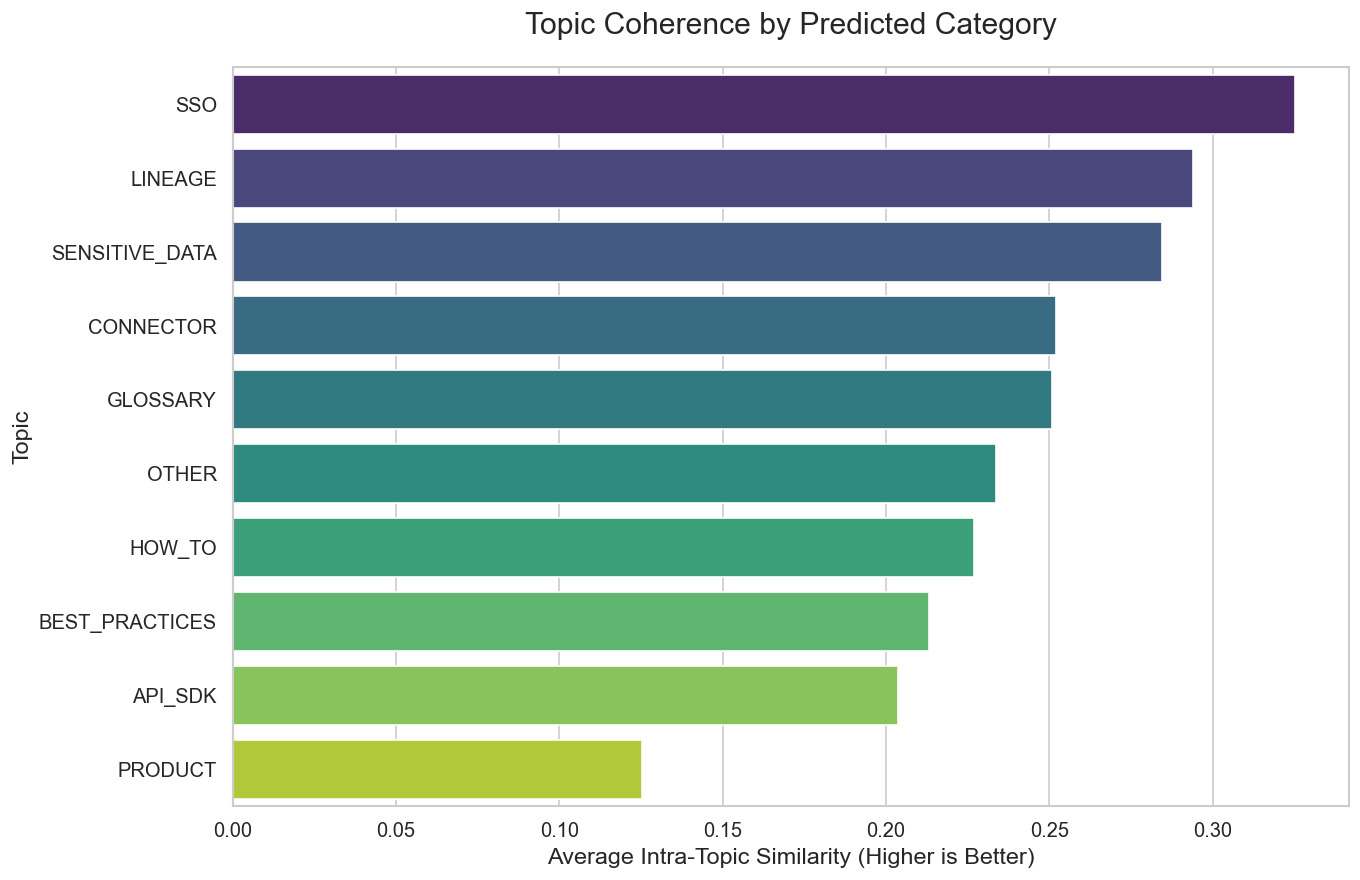

In [9]:
# Load the topic summary data
topic_summary_path = os.path.join(output_dir, "topic_summary.csv")
topic_df = pd.read_csv(topic_summary_path)

# Filter for topics with at least 3 tickets for a meaningful score
topic_df_filtered = topic_df[topic_df['size'] >= 3].dropna(subset=['coherence']).sort_values('coherence', ascending=False)

# Create the plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='coherence', y='topic', data=topic_df_filtered, palette='viridis', dodge=False)
ax.set_title('Topic Coherence by Predicted Category', fontsize=18, pad=20)
ax.set_xlabel('Average Intra-Topic Similarity (Higher is Better)', fontsize=14)
ax.set_ylabel('Topic', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.show()

Question 2: Are our topic definitions clear and distinct from each other?
For this, we use the 2D PCA (Principal Component Analysis) plot generated by our evaluation script. This technique visualizes the high-dimensional meaning of each ticket as a point on a 2D map. If our topics are well-defined, we should see distinct "clouds" of points for each topic with minimal overlap.

Displaying PCA plot of topic clusters:


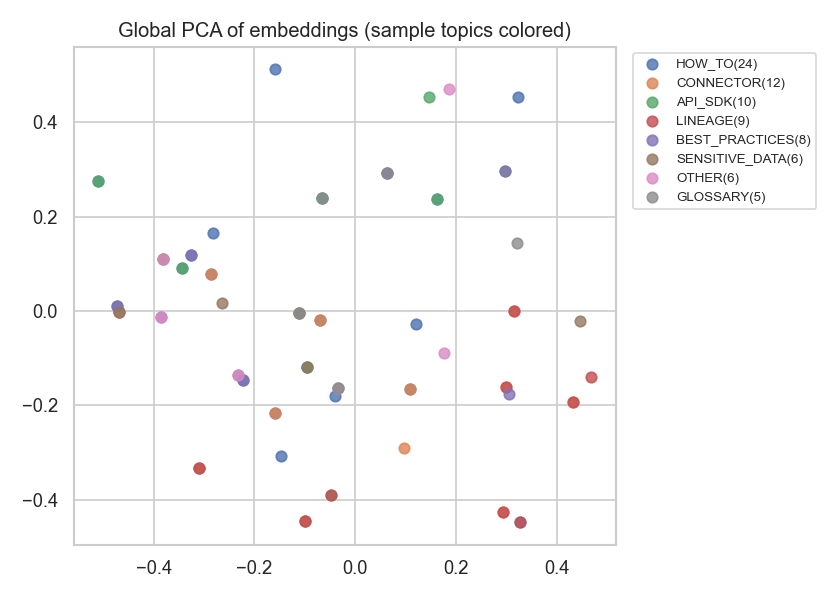

In [11]:
# The PCA plot was already generated by the run_evaluation function
pca_plot_path = os.path.join(output_dir, 'global_pca.png')
if os.path.exists(pca_plot_path):
    print("Displaying PCA plot of topic clusters:")
    display(Image(filename=pca_plot_path))
else:
    print("PCA plot not found.")

Question 3: Can the system identify ambiguous tickets for human review?
Here, we measure the Classification Margin for each ticket. This is the difference between the confidence score of the winning topic and the score of the runner-up. A high margin means the AI was very sure of its choice, while a low margin indicates ambiguity.

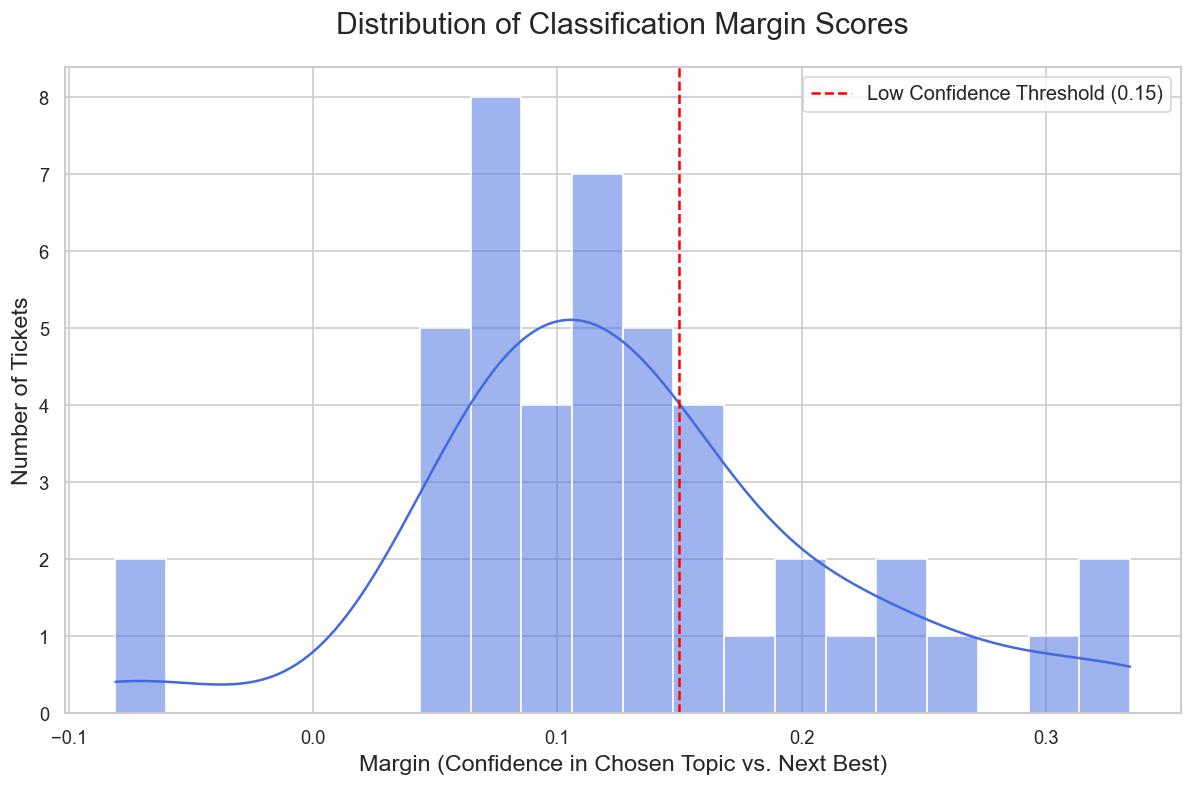

In [13]:
# Load the per-ticket metrics
tickets_metrics_path = os.path.join(output_dir, "tickets_with_metrics.csv")
tickets_df = pd.read_csv(tickets_metrics_path).dropna(subset=['margin'])

# Create the plot
plt.figure(figsize=(12, 7))
ax = sns.histplot(tickets_df['margin'], kde=True, bins=20, color='royalblue')
ax.set_title('Distribution of Classification Margin Scores', fontsize=18, pad=20)
ax.set_xlabel('Margin (Confidence in Chosen Topic vs. Next Best)', fontsize=14)
ax.set_ylabel('Number of Tickets', fontsize=14)
plt.axvline(x=0.15, color='red', linestyle='--', label='Low Confidence Threshold (0.15)')
plt.legend(fontsize=12)
plt.show()

## Final Answer Evaluation
While the Triage evaluation tells us if we're categorizing tickets correctly, we also need to evaluate the quality of the final, AI-generated answers. Evaluating generated text is more complex than a simple accuracy score. We will use a combination of automated metrics and prepare a report for qualitative review.


My evaluation will focus on two key automated metrics:

- Consistency: Does the system produce the same answer for the same question every time? An unstable system is an unreliable one.

- Robustness: Does the system produce the same answer for minor, meaningless variations of a question? It should not be easily thrown off by a user rephrasing their query.

To gather my data, I will run the full pipeline three times on my dataset of 45 tickets:

Run 1: On the original ticket bodies.

Run 2: On the original ticket bodies again, to check for consistency.

Run 3: On "perturbed" versions of the ticket bodies (e.g., converted to lowercase with extra words) to check for robustness.

In [ ]:
from sentence_transformers import SentenceTransformer, util
from atlan_helpdesk_pipeline import ChatbotPipeline

logging.info("--- Step 5: Final Answer Evaluation ---")

# Initialize the full pipeline
pipeline = ChatbotPipeline(historical_data=None)

# Initialize a model for semantic similarity comparison
similarity_model = SentenceTransformer('all-MiniLM-L6-v2')

run1_results = []
run2_results = []
perturbed_results = []

# Create the original and perturbed queries
original_queries = [ticket['body'] for ticket in full_dataset]
perturbed_queries = [ticket['body'].lower().strip() + " can you please help?" for ticket in full_dataset]

# --- Run 1: Original Queries ---
print("Executing Run 1 (Original Queries)...")
for i, query in enumerate(original_queries):
    if i > 0 and i % 12 == 0:
        print("Pausing for 60 seconds to avoid API rate limits...")
        time.sleep(60)
    print(f"Processing ticket {i+1}/{len(original_queries)}", end='\r')
    run1_results.append(pipeline.run(query=query, ticket_id=full_dataset[i]['id']))
print("\nRun 1 complete.")

# --- Run 2: Original Queries (for Consistency) ---
print("Executing Run 2 (Original Queries for Consistency)...")
for i, query in enumerate(original_queries):
    if i > 0 and i % 12 == 0:
        print("Pausing for 60 seconds to avoid API rate limits...")
        time.sleep(60)
    print(f"Processing ticket {i+1}/{len(original_queries)}", end='\r')
    run2_results.append(pipeline.run(query=query, ticket_id=full_dataset[i]['id']))
print("\nRun 2 complete.")

# --- Run 3: Perturbed Queries (for Robustness) ---
print("Executing Run 3 (Perturbed Queries for Robustness)...")
for i, query in enumerate(perturbed_queries):
    if i > 0 and i % 12 == 0:
        print("Pausing for 60 seconds to avoid API rate limits...")
        time.sleep(60)
    print(f"Processing ticket {i+1}/{len(perturbed_queries)}", end='\r')
    perturbed_results.append(pipeline.run(query=query, ticket_id=full_dataset[i]['id']))
print("\nRun 3 complete.")

#### Calculating Similarity Scores and Visualizing Results
Now, we'll use semantic similarity (cosine similarity) to compare the answers from our three runs. A score of 1.0 means the answers are identical in meaning.

In [ ]:
# Calculate semantic similarity scores
run1_answers = [res.final_answer for res in run1_results]
run2_answers = [res.final_answer for res in run2_results]
perturbed_answers = [res.final_answer for res in perturbed_results]

# Encode all answers at once for efficiency
embeddings1 = similarity_model.encode(run1_answers, convert_to_tensor=True)
embeddings2 = similarity_model.encode(run2_answers, convert_to_tensor=True)
embeddings_perturbed = similarity_model.encode(perturbed_answers, convert_to_tensor=True)

# Calculate pairwise cosine similarities
consistency_scores = util.cos_sim(embeddings1, embeddings2).diag().tolist()
robustness_scores = util.cos_sim(embeddings1, embeddings_perturbed).diag().tolist()

# Create a DataFrame for analysis
eval_data = {
    'ticket_id': [res.triage.ticket_id for res in run1_results],
    'subject': [ticket['subject'] for ticket in full_dataset],
    'consistency_score': consistency_scores,
    'robustness_score': robustness_scores,
    'answer_run1': run1_answers,
    'sources_run1': [res.rag_response.get('sources', []) for res in run1_results]
}
final_eval_df = pd.DataFrame(eval_data)

# Save the detailed results for manual review
report_path = os.path.join(output_dir, "final_answer_evaluation_report.csv")
final_eval_df.to_csv(report_path, index=False)
print(f"Detailed report for manual review saved to: {report_path}")

# Visualize the distributions
plt.figure(figsize=(14, 7))
sns.boxplot(data=final_eval_df[['consistency_score', 'robustness_score']], palette='pastel')
plt.title('Distribution of Final Answer Scores', fontsize=18, pad=20)
plt.ylabel('Semantic Similarity Score (1.0 = Identical)', fontsize=14)
plt.ylim(0.8, 1.01) # Zoom in on the top range for clarity
plt.show()

display(final_eval_df.head())